#### Step 1. Setup and Imports
Create a cell to import all necessary libraries and set up the device.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


#### Step 2. Define the Izhikevich Neuron Module
This cell defines the Izhikevich neuron dynamics. We use a simple discrete time approximation.

In [4]:
# Define the Izhikevich Neuron Module
class IzhikevichNeuron(nn.Module):
    def __init__(self, a=0.02, b=0.2, c=-65, d=8, v_peak=30):
        super(IzhikevichNeuron, self).__init__()
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.v_peak = v_peak

    def forward(self, v, u, I, dt=1.0):
        # Update membrane potential and recovery variable
        dv = (0.04 * v * v + 5 * v + 140 - u + I) * dt
        v = v + dv
        du = self.a * (self.b * v - u) * dt
        u = u + du

        # Generate spike (binary output)
        spikes = (v >= self.v_peak).float()
        # Reset dynamics after spike
        v = spikes * self.c + (1 - spikes) * v
        u = u + spikes * self.d
        return v, u, spikes

#### Step 3. Build a Spiking Convolutional Layer
This cell creates a convolutional layer that applies a convolution then passes the result through the Izhikevich neuron dynamics over a series of time steps. In a real implementation, you might have a spike-wave tensor (time, batch, channels, height, width).

In [5]:
# Step 3: Define a Spiking Convolutional Layer Using Izhikevich Neurons
class SpikingConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, neuron_params, padding=0):
        super(SpikingConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.neuron = IzhikevichNeuron(*neuron_params)
    
    def forward(self, input_spike_wave, time_steps, dt=1.0):
        # Assume input_spike_wave shape: [batch, channels, height, width]
        # We will simulate over "time_steps"
        batch_size, _, H, W = input_spike_wave.shape
        
        # Initialize membrane potential and recovery variable (set to zeros)
        # For simplicity, assume spatial dimensions reduce as per convolution parameters.
        conv_out = self.conv(input_spike_wave)
        v = torch.zeros_like(conv_out).to(input_spike_wave.device)
        u = torch.zeros_like(conv_out).to(input_spike_wave.device)
        
        # Record spikes over time
        spike_record = []
        for t in range(time_steps):
            # For demonstration, use the same convolution output as input current each time step.
            # In a more complex model, you may have time-varying input.
            I = conv_out  
            v, u, spikes = self.neuron(v, u, I, dt)
            spike_record.append(spikes)
        
        # Stack spike outputs: shape [time_steps, batch, out_channels, H_out, W_out]
        spike_record = torch.stack(spike_record, dim=0)
        return spike_record, v, u

# Test the layer with a dummy input
dummy_input = torch.rand(1, 1, 28, 28).to(device)
layer = SpikingConvLayer(in_channels=1, out_channels=10, kernel_size=5, neuron_params=(0.02, 0.2, -65, 8))
spike_output, v_final, u_final = layer(dummy_input, time_steps=10)
print("Spike output shape:", spike_output.shape)


Spike output shape: torch.Size([10, 1, 10, 24, 24])


#### Step 4. Data Transformation: Image to Spike-Wave Conversion
Here we define a simple transformation that converts an image into a “spike-wave” tensor. In this example, we use a latency coding approach where the intensity is mapped to a spike time.

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.64MB/s]

Spike-wave shape: torch.Size([10, 1, 28, 28])


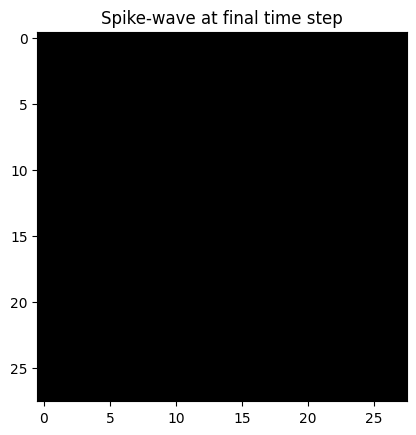

In [6]:
# Step 4: Data Transformation - Convert Images to Spike-Wave Tensors
def image_to_spike_wave(image, time_steps=10, threshold=0.5):
    """
    Convert an image tensor [C, H, W] into a spike-wave tensor [time_steps, C, H, W].
    A simple threshold-based latency coding is used.
    """
    # Normalize image to [0, 1] if necessary
    image = image / image.max()
    # Determine spike time: lower intensity = later spike
    # Here we simply invert the image intensity and scale to time steps.
    spike_times = (1 - image) * (time_steps - 1)
    spike_times = spike_times.long()
    
    # Create a binary spike-wave tensor
    C, H, W = image.shape
    spike_wave = torch.zeros(time_steps, C, H, W)
    for t in range(time_steps):
        spike_wave[t] = (spike_times <= t).float()  # Spike becomes 1 from its spike time onward
    return spike_wave

# Test the transformation on a sample image from MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_sample = transform(torchvision.datasets.MNIST(root='./data', train=True, download=True)[0][0])
spike_wave_sample = image_to_spike_wave(mnist_sample, time_steps=10)
print("Spike-wave shape:", spike_wave_sample.shape)
plt.imshow(spike_wave_sample[-1][0].numpy(), cmap='gray')
plt.title("Spike-wave at final time step")
plt.show()


#### Step 5. Define the Overall Network Architecture
This cell defines a simple network with two spiking convolutional layers and a fully connected layer for classification.

In [7]:
# Step 5: Define the Overall Spiking CNN Architecture
class SpikingCNN(nn.Module):
    def __init__(self, neuron_params, time_steps=10):
        super(SpikingCNN, self).__init__()
        self.time_steps = time_steps
        
        # Define two spiking convolutional layers
        self.layer1 = SpikingConvLayer(in_channels=1, out_channels=20, kernel_size=5, neuron_params=neuron_params, padding=2)
        self.layer2 = SpikingConvLayer(in_channels=20, out_channels=50, kernel_size=5, neuron_params=neuron_params, padding=2)
        
        # Fully connected layer for classification
        # Here, we assume the final spatial dimension remains 28x28; adjust pooling as needed.
        self.fc = nn.Linear(50 * 28 * 28, 10)
    
    def forward(self, input_image):
        # Convert image to spike-wave representation
        spike_wave = image_to_spike_wave(input_image, time_steps=self.time_steps)  # shape: [T, C, H, W]
        
        # Add batch dimension if needed: assume input_image shape [1, C, H, W]
        spike_wave = spike_wave.to(device)
        
        # Process through first spiking conv layer (apply on the last time slice or accumulate over time)
        spikes1, v1, u1 = self.layer1(spike_wave, self.time_steps)
        # For simplicity, take the last time-step output (or use pooling over time)
        spikes1_last = spikes1[-1]
        
        spikes2, v2, u2 = self.layer2(spikes1_last, self.time_steps)
        spikes2_last = spikes2[-1]
        
        # Flatten and feed into fully connected layer
        out_flat = spikes2_last.view(spikes2_last.size(0), -1)
        out = self.fc(out_flat)
        return out

# Instantiate the network and test on a single image
neuron_params = (0.02, 0.2, -65, 8)
model = SpikingCNN(neuron_params=neuron_params, time_steps=10).to(device)
sample_image = mnist_sample.unsqueeze(0).to(device)  # add batch dimension
output = model(sample_image)
print("Network output shape:", output.shape)


ValueError: too many values to unpack (expected 3)

#### Step 6. Define Training Functions Including STDP/R-STDP Placeholders
In this cell we create a training loop. The code includes a standard loss–backpropagation branch for demonstration and placeholders for incorporating STDP or reward-modulated STDP. (In a complete spiking network, you might replace backprop with your plasticity rules.)

In [8]:
# Step 6: Training Loop and STDP/R-STDP Placeholders
def train_epoch(model, data_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(data_loader):
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        # For simplicity, process one image at a time
        optimizer.zero_grad()
        
        # Process each image individually (or modify for batch processing)
        outputs = []
        for img in images:
            img = img.unsqueeze(0)  # add batch dimension
            output = model(img)
            outputs.append(output)
        outputs = torch.cat(outputs, dim=0)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # ----- STDP / R-STDP Placeholder -----
        # Here you would add your custom plasticity rule updates (STDP / R-STDP)
        # For example:
        # if correct_prediction:
        #     apply_reward_modulation()
        # else:
        #     apply_punishment_modulation()
        # --------------------------------------
        
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}], Batch [{batch_idx}], Loss: {loss.item():.4f}")
    return running_loss / len(data_loader)

# Setup MNIST dataset and DataLoader
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train for a few epochs
for epoch in range(1, 4):
    avg_loss = train_epoch(model, train_loader, optimizer, criterion, epoch)
    print(f"Average Loss for epoch {epoch}: {avg_loss:.4f}")


ValueError: too many values to unpack (expected 3)

#### Step 7. Evaluation
Finally, add a cell to evaluate your network on the test dataset.

In [9]:
# Step 7: Evaluation Function
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = []
            for img in images:
                img = img.unsqueeze(0)
                output = model(img)
                outputs.append(output)
            outputs = torch.cat(outputs, dim=0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

# Setup MNIST test dataset and DataLoader
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
evaluate(model, test_loader)


ValueError: too many values to unpack (expected 3)